In [1]:
import pandas
import torch
import pickle
import training
import utilities
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
import nltk
import sklearn.metrics.pairwise


%matplotlib inline


dataDir = 'data'
modelsDir = 'models'

rawFname = 'Stats-journs.tsv'
manualFname = 'classified.yaml'

w2vFname = 'word2vec.bin'
pickleFname = 'dfPickles.p'
regenW2V = False

eta = 0.001
numEpochs = 50
epochSize = 500

In [2]:
def compareRows(rows, N, useTitle = True, w2v = None):
    fig, axes = plt.subplots(figsize = (20,25),
                             nrows = len(rows) + 1,
                             gridspec_kw = {'height_ratios': [5] * len(rows) + [1]})
    aLst = []
    for i, row in enumerate(rows):
        if 'title_vecs' in row:
            abVec, tiVec, yVec = utilities.varsFromRow(row)
        else:
            abVec, tiVec, yVec = utilities.varsFromRow(row, w2v)
        if useTitle:
            outLSTM, (h_n, c_n) = N.lstmTi(tiVec)
            s = row['title']
        else:
            outLSTM, (h_n, c_n) = N.lstmAb(abVec)
            s = row['abstract']
        out = N(abVec, tiVec)
        probNeg = np.exp(out.data[0][0])
        probPos = np.exp(out.data[0][1])            
        probNeg = probNeg / (probNeg + probPos)
        probPos = probPos / (probNeg + probPos)
        
        a = np.array(outLSTM.data.tolist())
        aLst.append(a[0, -1, :])
        #a = a[:,:100,:]
        df = pandas.DataFrame(a[0, :, :])
        df.index = nltk.word_tokenize(s)[:a.shape[1]]
        seaborn.heatmap(df, ax = axes[i])
        axes[i].set_title("Article Title: '{}'\n$P_{{negative}} = {:.4f}, P_{{positive}} = {:.4f}$".format(row['title'], probNeg, probPos), fontsize = 20)
        axes[i].set_xticklabels([])
        
    
    dfDiff = pandas.DataFrame(np.stack([aLst[0], np.fabs(aLst[0] - aLst[1]), aLst[1]]))
    dfDiff.index = ['Top', 'Diff', 'Bottom']
    seaborn.heatmap(dfDiff, ax = axes[-1], xticklabels = [i if i in np.linspace(0, len(dfDiff.columns) - 1, num = 10, dtype='int') else '' for i in range(len(dfDiff.columns))])
    axes[-1].set_title('Difference in Final Output Vectors', fontsize = 20)
    
    return fig, axes

In [99]:
def wordDiff(df, N, useTitle = True, w2v = None):
    wDiffs = {}
    for i, (n, row) in enumerate(df.iterrows()):
        print("{:.0f}% Done".format(i / len(df) * 100), end = '\r')
        if 'title_vecs' in row:
            abVec, tiVec, yVec = utilities.varsFromRow(row)
        else:
            abVec, tiVec, yVec = utilities.varsFromRow(row, w2v)
        if useTitle:
            outLSTM, (h_n, c_n) = N.lstmTi(tiVec)
            s = row['title']
        else:
            outLSTM, (h_n, c_n) = N.lstmAb(abVec)
            s = row['abstract']
        if not isinstance(s, str):
            continue
        out = N(abVec, tiVec)
        a = np.array(outLSTM.data.tolist())[0]
        diffs = []
        for i in range(a.shape[0]):
            try:
                dU = 1 - sklearn.metrics.pairwise.cosine_similarity(a[i - 1].reshape(1, -1), a[i].reshape(1, -1))
            except IndexError:
                dU = 0
            try:
                dD = 1 - sklearn.metrics.pairwise.cosine_similarity(a[i + 1].reshape(1, -1), a[i].reshape(1, -1))
                if dU == 0:
                    dU = dD
            except IndexError:
                dD = dU
            diffs.append(np.mean([dU,dD]))
            
        for d, w in zip(diffs, nltk.word_tokenize(s.lower())):
            if w in wDiffs:
                wDiffs[w].append(d)
            else:
                wDiffs[w]= [d]
    return {w : np.mean(d) for w, d in wDiffs.items()}

In [96]:
def wordDiffPlot(row, N, useTitle = True, w2v = None):
    fig, ax = plt.subplots(figsize = (10,5))
    if 'title_vecs' in row:
        abVec, tiVec, yVec = utilities.varsFromRow(row)
    else:
        abVec, tiVec, yVec = utilities.varsFromRow(row, w2v)
    if useTitle:
        outLSTM, (h_n, c_n) = N.lstmTi(tiVec)
        s = row['title']
    else:
        outLSTM, (h_n, c_n) = N.lstmAb(abVec)
        s = row['abstract']
    out = N(abVec, tiVec)
    a = np.array(outLSTM.data.tolist())[0]
    diffs = []
    for i in range(a.shape[0]):
        try:
            dU = 1 - sklearn.metrics.pairwise.cosine_similarity(a[i - 1].reshape(1, -1), a[i].reshape(1, -1))
        except IndexError:
            dU = 0
        try:
            dD = 1 - sklearn.metrics.pairwise.cosine_similarity(a[i + 1].reshape(1, -1), a[i].reshape(1, -1))
            if dU == 0:
                dU = dD
        except IndexError:
            dD = dU
        diffs.append(np.mean([dU,dD]))
    dfDiffs = pandas.DataFrame({'diff' : diffs})
    #dfDiffs['loc'] = dfDiffs.index
    dfDiffs.index = nltk.word_tokenize(s)
    dfDiffs = dfDiffs#[1:-1]
    dfDiffs.plot(ax = ax)
    print("Done      ")
    return dfDiffs

In [3]:
with open("models/BiRNN-2-256-9.pt", 'rb') as f:
    N = torch.load(f)
N.cuda()

/Users/Reid/anaconda/lib/python3.6/site-packages/torch/serialization.py:284: SourceChangeWarning: source code of class 'neuralnet.BiRNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


BiRNN-2-256-9

In [56]:
df, w2v = utilities.preprocesing(dataDir, rawFname, modelsDir, w2vFname, pickleFname)
dfTrain, dfTest = utilities.getTrainTest(df, dataDir, manualFname, w2v)
df.index = df['wos_id']

Loading W2V
Loading DF
Generating training and testing sets
Generating word vectors
Enriching training set


In [57]:
print('There are {} total records'.format(len(df)))

There are 78971 total records


In [58]:
regen = False
if regen:
    catsDict = {
        'title' : [],
        'wos_id' : [],
        'abstract' : [],
        'source' : [],
        'weightP' : [],
        'weightN' : [],
    }

    tDF = df
    for i, row in tDF.iterrows():
        print(i / len(tDF), end = '\r')
        try:
            abVec, tiVec, yVec = utilities.varsFromRow(row, w2v)
            out = N(abVec, tiVec)
        except Exception as e:
            print(e)
            print(row['wos_id'])
            continue
        catsDict['weightN'].append(out.data[0][0])
        catsDict['weightP'].append(out.data[0][1])
        catsDict['title'].append(row['title'])
        catsDict['wos_id'].append(row['wos_id'])
        catsDict['abstract'].append(row['abstract'])
        catsDict['source'].append(row['source'])
    dfY = pandas.DataFrame(catsDict)
else:
    dfY = pandas.read_csv('outputs/withYears.csv', index_col='wos_id')
dfY = dfY.drop(float('nan'))
dfY['isSoftware'] = dfY['weightP'] > dfY['weightN']
dfY['New software'] = dfY['isSoftware']

In [59]:
dfYearCounts = dfY.groupby(['New software', 'pubyear'])['pubyear'].count()
dfYearCounts = pandas.DataFrame({'True' : dfYearCounts.loc[True], 'False' : dfYearCounts.loc[False],'tot' : df.groupby(['pubyear'])['pubyear'].count()})
dfYearCounts['ratio'] = dfsummary['True'] / dfsummary['tot']
dfYearCounts[['tot', 'False', 'True', 'ratio']]

,tot,False,True,ratio
pubyear,,,,
2005,5235,4998,237,0.045272
2006,5806,5522,284,0.048915
2007,6255,5914,341,0.054516
2008,7085,6703,382,0.053917
2009,7435,7047,388,0.052186
2010,7216,6800,415,0.057511
2011,7767,7280,487,0.062701
2012,7990,7519,471,0.058949
2013,8287,7829,458,0.055267


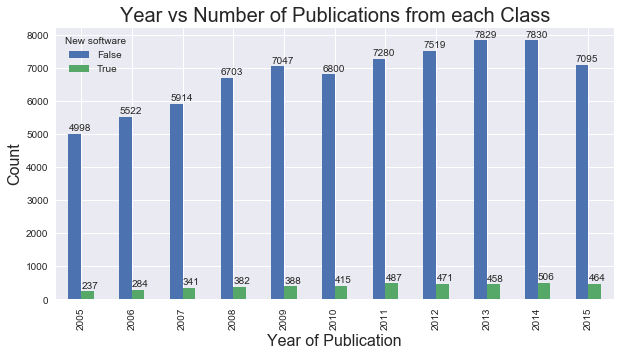

In [60]:
fig, ax = plt.subplots(figsize = (10, 5))
x_offset = -0.12

dfPlt = dfY.groupby(['New software', 'pubyear'])['pubyear'].count().unstack('New software')
dfPlt.plot(kind='bar', ax = ax)#, stacked=True)
ax.set_ylabel('Count', fontsize=16)
ax.set_xlabel('Year of Publication', fontsize=16)
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 +100))
ax.set_title('Year vs Number of Publications from each Class', fontsize=20)
#plt.savefig('images/countvyear.pdf', format='pdf')
plt.show()

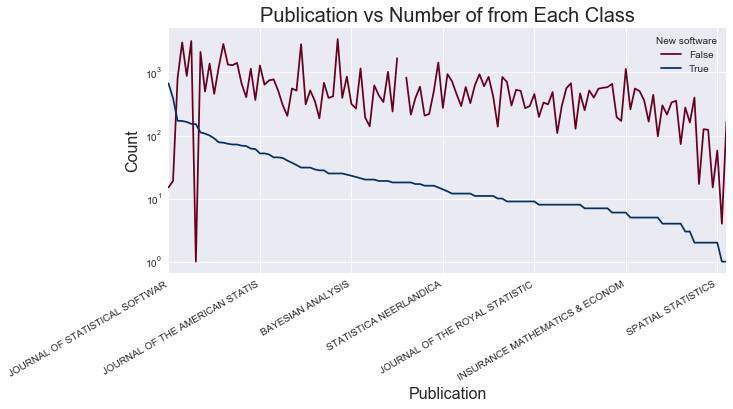

In [61]:
fig, ax = plt.subplots(figsize = (10, 5))
x_offset = -0.12

df2 = dfY.groupby(['New software', 'source'])['source'].count().unstack('New software')
df2 = df2[df2[True] > 0]
df2.index = [s[:30] for s in df2.index]
df2.sort_values(by=True,ascending=False).plot(kind='line', ax = ax, colormap= "RdBu")
ax.set_ylabel('Count', fontsize=16)
ax.set_xlabel('Publication', fontsize=16)
#ax.xticks = [s if i % 2 ==0 else '' for i, s in enumerate(df2.index)]
ax.set_title('Publication vs Number of from Each Class', fontsize=20)
#plt.savefig('images/countvyear.pdf', format='pdf')
fig.autofmt_xdate()
ax.semilogy()
plt.savefig('images/countvpub.pdf', format='pdf', transparent = False)

plt.show()

In [62]:
tJ = [
    'STATISTICAL METHODS IN MEDICAL RESEARCH',
    'JOURNAL OF THE ROYAL STATISTICAL SOCIETY SERIES B-STATISTICAL METHODOLOGY',
    'ECONOMETRICA',
    'BRITISH JOURNAL OF MATHEMATICAL & STATISTICAL PSYCHOLOGY',
    'ANNUAL REVIEW OF STATISTICS AND ITS APPLICATION',
    'ANNALS OF STATISTICS',
    'STOCHASTIC ENVIRONMENTAL RESEARCH AND RISK ASSESSMENT',
    'TECHNOMETRICS',
]
dfSourceCounts = dfY.groupby(['isSoftware', 'source']).size()
dfSourceCounts.loc[False].sort_values(ascending=False)[tJ]#.plot()

source
STATISTICAL METHODS IN MEDICAL RESEARCH                                       354.0
JOURNAL OF THE ROYAL STATISTICAL SOCIETY SERIES B-STATISTICAL METHODOLOGY     393.0
ECONOMETRICA                                                                  627.0
BRITISH JOURNAL OF MATHEMATICAL & STATISTICAL PSYCHOLOGY                      268.0
ANNUAL REVIEW OF STATISTICS AND ITS APPLICATION                                 NaN
ANNALS OF STATISTICS                                                         1156.0
STOCHASTIC ENVIRONMENTAL RESEARCH AND RISK ASSESSMENT                        1025.0
TECHNOMETRICS                                                                 395.0
dtype: float64

In [63]:
r1 = df.loc['WOS:000272110900028']
r2 = df.loc['WOS:000280216700014']

In [64]:
#row = df.loc['WOS:000272110900028']
print("r1")
print(r1['title'])
print()
print(r1['abstract'])
print(r1['pubyear'])
print("\nr2")
print(r2['title'])
print()
print(r2['abstract'])
print(r2['pubyear'])

r1
Clustering of discretely observed diffusion processes

A new distance to classify time series is proposed. The underlying generating process is assumed to be a diffusion process solution to stochastic differential equations and observed at discrete times. The mesh of observations is not required to shrink to zero. The new dissimilarity measure is based on the L-1 distance between the Markov operators estimated on two observed paths. Simulation experiments are used to analyze the performance of the proposed distance under several conditions including perturbation and misspecification. As an example, real financial data from NYSE/NASDAQ stocks are analyzed and evidence is provided that the new distance seems capable to catch differences in both the drift and diffusion coefficients better than other commonly used non-parametric distances. Corresponding software is available in the add-on package sde for the R statistical environment. (C) 2009 Elsevier B.V. All rights reserved.
2010

r2

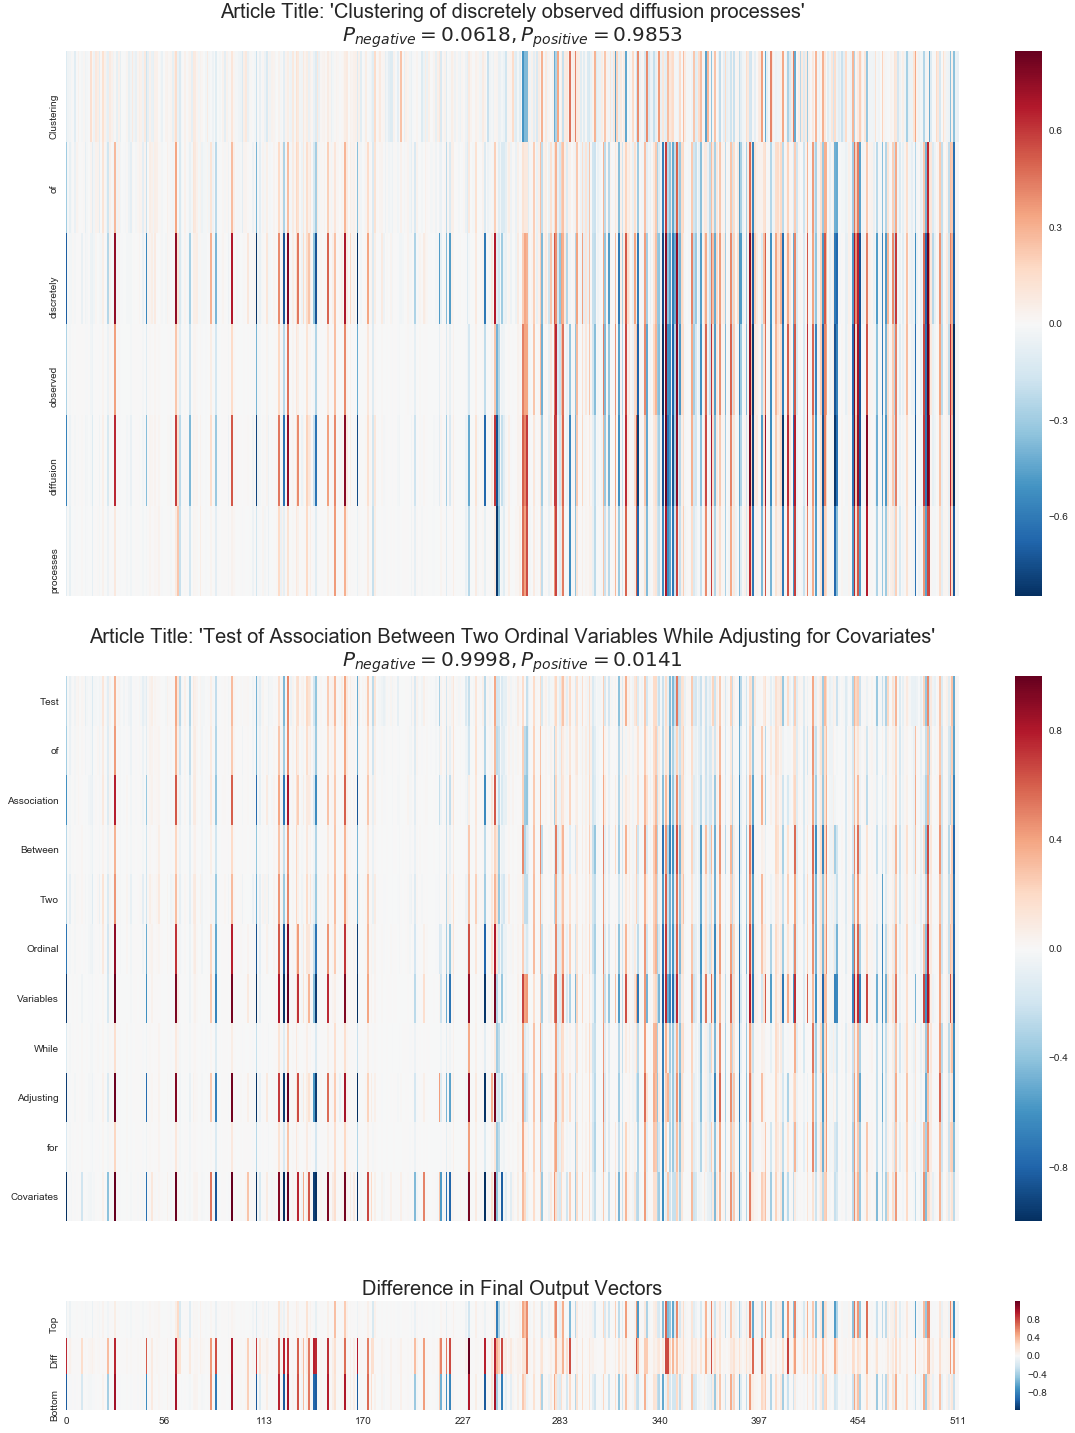

In [65]:
compareRows([r1, r2],N, w2v = w2v)
#plt.savefig('images/comparisonTitle.pdf', format  = 'pdf', transparent=True)
plt.show()

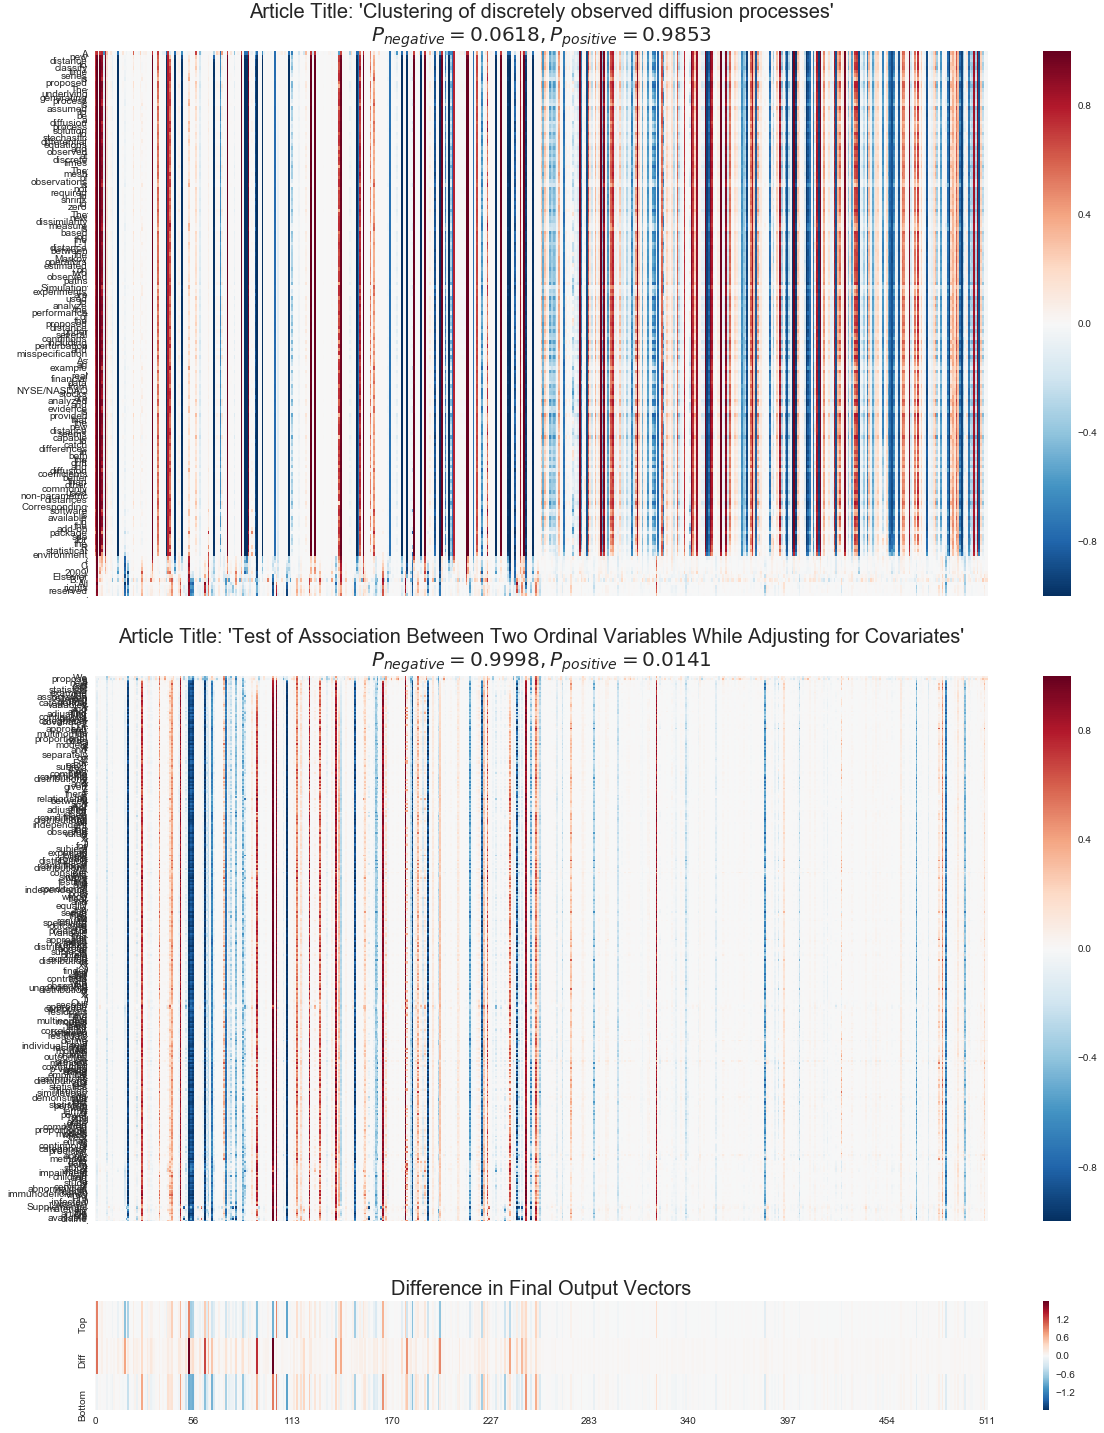

In [66]:
compareRows([r1, r2],N, useTitle=False, w2v = w2v)
#plt.savefig('images/comparisonTitle.pdf', format  = 'pdf', transparent=True)
plt.show()

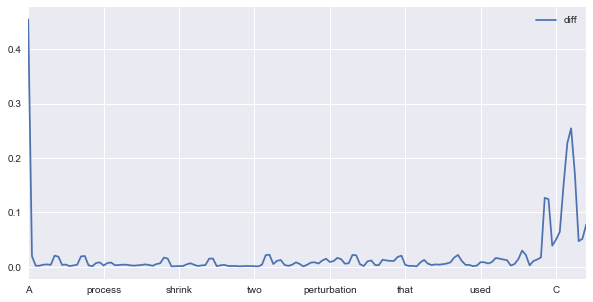

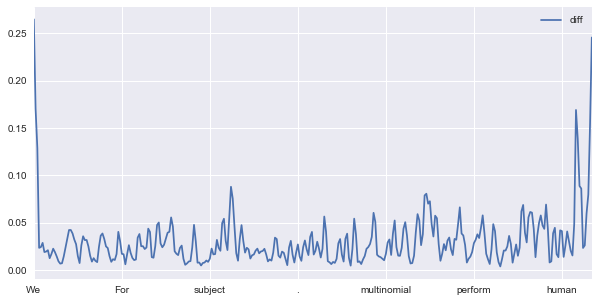

In [75]:
dfDiffs= wordDiffPlot(r1, N, useTitle = False, w2v = w2v)
plt.show()
dfDiffs= wordDiffPlot(r2, N, useTitle = False, w2v = w2v)
plt.show()

In [76]:
idsPython = [w for w, t in zip(dfY.index, dfY['abstract']) if 'python' in t.lower()]

In [ ]:
wD = wordDiff(df[:100], N, useTitle = False, w2v = w2v)
indices = []
vals = []
for k, v in wD.items():
    indices.append(k)
    vals.append(v)

dfDiffs = pandas.DataFrame({'diff' : vals})
dfDiffs.index = indices
dfDiffs.sort_values('diff',ascending=False)

In [5]:
for i in range(20):
    row = dfs['some'].sample(n = 1).iloc[0]
    abVec, tiVec, yVec = main.varsFromRow(row)
    print(row['title'])
    out = N(abVec, tiVec)
    print(np.argmax(out.data[0].tolist()), end = '\t')
    print(out.data[0].tolist())

Prediction of microRNA targets in Caenorhabditis elegans using a self-organizing map
0	[2.8573930263519287, -2.7012553215026855]
An efficient parallel algorithm for accelerating computational protein design
0	[1.8298288583755493, -1.6601485013961792]
ASEdb: a database of alanine mutations and their effects on the free energy of binding in protein interactions
0	[2.8871312141418457, -2.719616651535034]
Dynamic patterns of technological convergence in printed electronics technologies: patent citation network
0	[2.6769351959228516, -2.5010623931884766]
Shiny-phyloseq: Web application for interactive microbiome analysis with provenance tracking
1	[-1.3711847066879272, 1.4626030921936035]
RANKPROP: a web server for protein remote homology detection
0	[1.7101467847824097, -1.5785058736801147]
A calibration method for estimating absolute expression levels from microarray data
0	[3.1410725116729736, -3.0066328048706055]
A discrete view on fold space
1	[-0.7219773530960083, 0.832671046257019]
A